**Level-3: Architecture Enhancement using Channel Attention**


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

DATA_DIR = "./data"
BATCH_SIZE = 128
NUM_WORKERS = 4
SEED = 42
EPOCHS = 5
LR = 5e-4

torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**Data Augmentation**

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(128, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

eval_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


**Dataset Preparation**

In [ ]:
full_train_dataset = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=eval_transform
)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

val_dataset.dataset.transform = eval_transform

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


**Channel-wise Attention Module (Squeeze-and-Excitation)**


In [ ]:
# custom cnn designed to progressively reduce spatial dimensions
# while preserving semantic features
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


**ResNet-18 with SE Attention**


In [ ]:
import torchvision.models as models

class ResNet18_SE(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        base = models.resnet18(pretrained=True)

        self.features = nn.Sequential(
            base.conv1,
            base.bn1,
            base.relu,
            base.maxpool,
            base.layer1,
            base.layer2,
            base.layer3,
            base.layer4,
        )

        self.se = SEBlock(512)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)


In [ ]:
model = ResNet18_SE(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(loader, leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [ ]:
# fine-tuning the attention-augmented architecture
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    scheduler.step()

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )


Epoch [1/5] | Train Acc: 0.8641 | Val Acc: 0.8997


Epoch [2/5] | Train Acc: 0.9402 | Val Acc: 0.9175


Epoch [3/5] | Train Acc: 0.9767 | Val Acc: 0.9182


Epoch [4/5] | Train Acc: 0.9951 | Val Acc: 0.9403


Epoch [5/5] | Train Acc: 0.9995 | Val Acc: 0.9466


**Final Evaluation**

In [ ]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Final Test Accuracy (Level-3): {test_acc:.4f}")


Final Test Accuracy (Level-3): 0.9435


**Per-class accuracy**

In [ ]:
CIFAR10_CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

for i, cls in enumerate(CIFAR10_CLASSES):
    acc = (all_preds[all_labels == i] == i).mean()
    print(f"{cls:12s}: {acc:.4f}")


airplane    : 0.9670
automobile  : 0.9690
bird        : 0.9300
cat         : 0.8810
deer        : 0.9420
dog         : 0.8860
frog        : 0.9740
horse       : 0.9550
ship        : 0.9680
truck       : 0.9630


**Gradient-weighted Class Activation Maps**

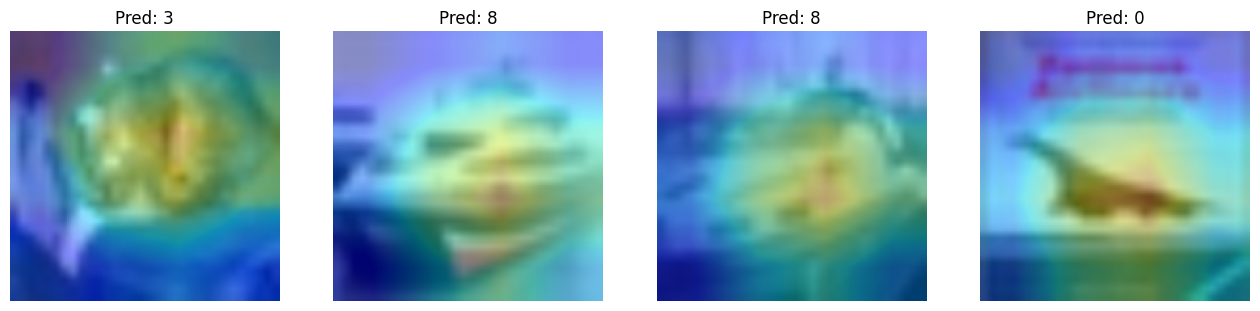

In [ ]:
import torch.nn.functional as F
import matplotlib.cm as cm

model.eval()

target_layer = model.features[-1]

grads = []
activations = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    grads.append(grad_output[0])

# Register hooks
fh = target_layer.register_forward_hook(forward_hook)
bh = target_layer.register_full_backward_hook(backward_hook)

# Load batch
images, labels = next(iter(test_loader))
images = images[:4].to(device)

# Forward
outputs = model(images)
preds = outputs.argmax(dim=1)

fig, axes = plt.subplots(1, 4, figsize=(16,4))

for i in range(4):
    model.zero_grad()
    outputs[i, preds[i]].backward(retain_graph=True)

    grad = grads[-1][i]          # [C,H,W]
    act = activations[-1][i]     # [C,H,W]

    weights = grad.mean(dim=(1,2))
    cam = torch.sum(weights[:, None, None] * act, dim=0)

    cam = F.relu(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    cam = F.interpolate(
        cam.unsqueeze(0).unsqueeze(0),
        size=images.shape[2:],
        mode="bilinear",
        align_corners=False
    ).squeeze().detach().cpu().numpy()

    img = images[i].detach().cpu()
    img = img.permute(1,2,0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    heatmap = cm.jet(cam)[..., :3]
    overlay = 0.6 * img + 0.4 * heatmap

    axes[i].imshow(overlay)
    axes[i].set_title(f"Pred: {preds[i].item()}")
    axes[i].axis("off")

plt.show()

fh.remove()
bh.remove()
